In [67]:
#!/usr/bin/env python
# coding: utf-8

#  Importar Paquetes

# In[1]:



from CoachAIUtils import *
import re
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
import numpy as np
from keras.utils import to_categorical
from keras import metrics
import matplotlib.pyplot as plt
import IPython.display as ht
from keras.callbacks import TensorBoard
from time import time
from ipywidgets import *
from sklearn.linear_model import LogisticRegression
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
import random as rn
import os
from keras import backend as K
from keras.models import load_model

jupy = True
debug = True

setpar = {}

# In[2]:


# @markdown Mostrar todos los detalles:
debug = True  # @param {type:"boolean"}
logset = []
grafancho = 12
grafalto = 6
multiyear = True
loadfich = ""
lota = 1.3  # @param {type:"slider", min:0, max:10, step:0.1}
lotb = 1  # @param {type:"slider", min:0, max:10, step:0.1}
lotc = 0.5  # @param {type:"slider", min:0, max:10, step:0.1}
lotd = 0.1  # @param {type:"slider", min:0, max:10, step:0.1}

# Conectar a BD
con = conectamysql("mysql+pymysql://{}:{}@{}/{}".format(user, passwd, host, db))
dfhead = pd.read_sql("select distinct EASetName from easet", con)
df = pd.read_sql("select distinct ﻿EASetName, Modifications from easettrades", con)
easetlist = df["﻿EASetName"].unique()



# Selección de Datos
# ___________________________
# Sets a incluir en test:ptestsetlist
# 
# Años a incluir en test:ptestyearlist
# 


easetstest = []
yearstest = []
loadedsets = []
testsetlist = "0,1"
testyearlist = "2015,2016,2017,2018,2019"
dire=".\\"
trd = np.array(np.zeros((1, 10000, 70)), dtype=object)

def cargaseldatos(ptestsetlist,ptestyearlist, pmultiyear, plota, plotb, plotc, plotd, pgrafancho, pgrafalto, ploadfich):
    global trd, loadedsets, setpar, loadfich, grafancho, grafalto, multiyear, lota, lotb, lotc, lotd, model

    for y in ptestsetlist.split(","):
        easetstest.append(easetlist[int(y)])

    for y in ptestyearlist.split(","):
        yearstest.append(y)

    trd = np.array(np.zeros((len(easetstest), 10000, 70)), dtype=object)
    dfmulti = ""
    for st in easetstest:
        dfmulti += "'{}',".format(st)

    dfmulti = dfmulti[:-1]
    print("Cargando {}".format(dfmulti))
    dftodos = pd.read_sql("select * from easettrades where ﻿EASetName IN ({}) ORDER BY 1, 3 ".format(dfmulti), con)

    i = 0
    for st in dftodos["﻿EASetName"].unique():
        dfsingle = dftodos[dftodos["﻿EASetName"] == st]
        trd[i, 0:dfsingle.shape[0], 0:dfsingle.shape[1]] = dfsingle.values
        i += 1

    lota = plota
    lotb = plotb
    lotc = plotc
    lotd = plotd
    grafancho = pgrafancho
    grafalto = pgrafalto
    multiyear = pmultiyear
    loadfich = ploadfich

    if ploadfich != "":
        setpar = json.load(open(dire + "setpar-" + ploadfich + ".json"))
        model = load_model(dire + loadfich + ".h5")
        print ("Cargado "+ ploadfich)

    return "Cargado"

def muestrasets():
    print("Sets Disponibles:")

    i = 0
    s = "<table><tr>"
    for st in easetlist:
        s += "<td>{}</td><td>{}</td>".format(i, nombrebueno(df, st))
        if i % 4 == 0:
            s += "</tr><tr>"
        i += 1
    s += "</tr></table>"
    if jupy:
        ht.display(ht.HTML(s))
    else:
        print(s)

    faltansets = False
    for st in dfhead["EASetName"].unique():
        if len(df[df["﻿EASetName"] == st]) == 0:
            if faltansets is False:
                print("Sets Parseados pero no disponibles:")
                faltansets = True
            print(st)

    if faltansets is False:
        print("Ninguno")
    return

def create_dataset(dataset, pcol, plback=2, plfwd=0):
    testx, testy, testadd, desctrain, desctest = [], [], [], [], []
    cols = {"easet": 0, "ticket": 1, "apertura": 4, "cierre": 5, "lote": 8, "pl": 28, "acc": 29}
    salto = 1 if setpar["overlap"] else setpar["eslabones"]
    lookback = plback * salto
    lookahead = plfwd * salto

    tot = 1
    for i in range(len(dataset)):
        for j in range(0, len(dataset[i]) - lookback - lookahead, salto):
            a = dataset[i, range(j, j + lookback, salto), pcol]
            b = dataset[i, j + lookback + lookahead, pcol]
            if b == 0.0 :
                continue
            c = dataset[i, j + lookback + lookahead, (cols["easet"], cols["easet"], cols["ticket"], cols["apertura"], cols["cierre"],
                                                      cols["lote"], cols["pl"], cols["acc"])]
            c[6] += sum(dataset[i, j + lookback + lookahead - salto:j + lookback + lookahead, cols["pl"]])
            c[3] = fechabuena(c[3])
            ano = c[3][:4]
            c[4] = fechabuena(c[4])
            c[1] = nombrebueno(df, c[1])
            desc = c[1] + "/" + ano

            if (c[0] in easetstest) and (ano in yearstest):
                testx.append(a)
                testy.append(b)
                testadd.append(c)
                if desc not in desctest:
                    desctrain.append(desc)
            tot += 1

    if debug:
        print("Sets con los que Graficará:", desctest)
    return np.array(testx), np.array(testy), np.array(testadd)


# Datos de Set

## Selección de Datos
##  ___________________________
Sets a incluir en training:ptrainsetlist

Años a incluir en training:ptrainyearlist

Sets a incluir en test:ptestsetlist

Años a incluir en test:ptestyearlist
 
## Parámetros Set
## ______________
pmodeltype: Modelo

peslabones: Tipo de eslabon (eg: 5 mira los 5 ultimos trades)

plook_back: Longitud de la cadena (eg: 10 entrena con los ultimos 10 eslabones)

plook_fwd: Lag de la predicción (0 intenta predecir siguiente eslabon, 1 dos eslabones despues...)

pruns: Numero de veces que entrenamos

Eslabones solapados o secuenciales:poverlap

Si marcas multiyear, habra un grafico por set y no por año: pmultiyear

Nuevo lotaje:plota, plotb, plotc, plotd

Tamaño Gráficos:pgrafancho, pgrafalto
 
## Parametros de los modelos:
## __________________________
Número de pasadas:pepochs

Número de elementos en cada pasada:pbatch_size

% de los datos que se usan para validación:pvalidation_split

Optimizador: poptimizador

Learning Rate: Tamaño de la actualizacion en gradient descent:plr

Reduccion progresiva del learning rate:pdecay

Celdas a desactivar cada pasada del estado oculto para prevenir overfitting:pdropout

Celdas a desactivar de la "memoria" para prevenir overfitting:precurrent_dropout
 

In [68]:
interact_manual(cargaseldatos,
        ptestsetlist = testsetlist,
        ptestyearlist = testyearlist,
        pmultiyear=multiyear,  # @param {type:"boolean"}
        plota=lota,  # @param {type:"slider", min:0, max:10, step:0.1}
        plotb=lotb,  # @param {type:"slider", min:0, max:10, step:0.1}
        plotc=lotc,  # @param {type:"slider", min:0, max:10, step:0.1}
        plotd=lotd,  # @param {type:"slider", min:0, max:10, step:0.1}
        pgrafancho=grafancho,  # @param {type:"slider", min:3, max:100, step:1}
        pgrafalto=grafalto,  # @param {type:"slider", min:3, max:100, step:1}
        ploadfich = loadfich)

print("Configuraciones de Sets")
for parfich in os.listdir(dire):
    if re.match("setpar.*.json", parfich):
        print(parfich[7:-5])


interactive(children=(Text(value='0,1', description='ptestsetlist'), Text(value='2015,2016,2017,2018,2019', de…

Configuraciones de Sets
17oct19
18oct19
20Oct19


Sets con los que Graficará: []
(279, 3)


________________________________________________________________________
Matriz de Confusión (Corr/Pred)	A		B		C		D
Predicción A: 	54/106 			54 		5 		24 		23
Predicción B: 	10/22 			0 		10 		4 		8
Predicción C: 	6/15 			0 		2 		6 		7
Predicción D: 	13/38 			1 		11 		13 		13
Reales (Corr 83/Reales 181) 	54/55 	10/28 	6/47 	13/51
_________________________________________________________________________


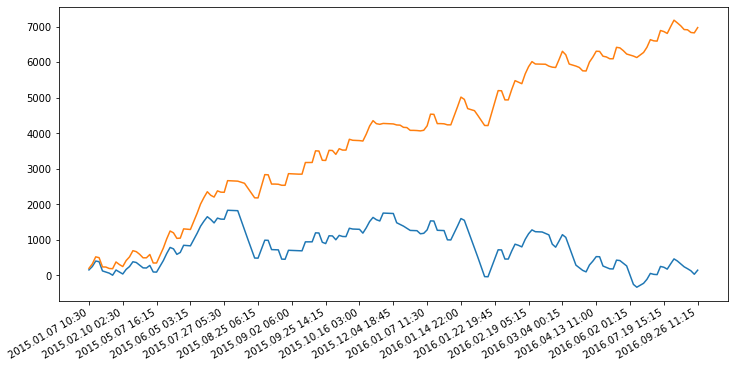

________________________________________________________________________
Matriz de Confusión (Corr/Pred)	A		B		C		D
Predicción A: 	32/53 			32 		0 		16 		5
Predicción B: 	6/16 			0 		6 		0 		10
Predicción C: 	3/5 			0 		0 		3 		2
Predicción D: 	12/24 			0 		2 		10 		12
Reales (Corr 53/Reales 98) 	32/32 	6/8 	3/29 	12/29
_________________________________________________________________________


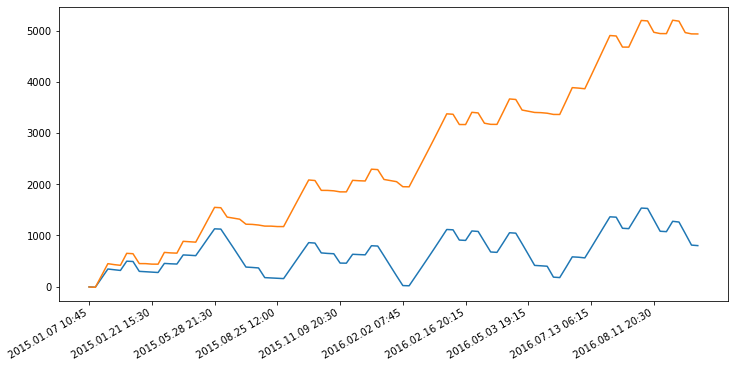

In [70]:

# In[5]:


def drawcolor(draw):
    return "black" if draw < 1500 else "red"


def grafica(pltdate, pltold, pltnew, oldea, oldano, corr, improv, oldacc, newacc, maxolddraw, maxnewdraw, posoldacc,
            negoldacc, posnewacc, negnewacc, maxoldpl, maxoldacc, minoldpl, minoldacc, maxnewpl, maxnewacc, minnewpl, minnewacc, avgposoldpl, avgnegoldpl,
            avgposnewpl, avgnegnewpl, confusion):
    precision = corr * 100 / len(pltdate)
    s = "<h2>Resumen de {} desde {} hasta {} - {} trades</h2>".format(nombrebueno(df, oldea), pltdate[0], pltdate[-1],
                                                                      len(pltdate))
    s += "<h3>{:.2f}% Mejorados ({} de {}) - ".format(improv * 100 / len(pltdate), improv, len(pltdate))
    s += "{:.2f}% Precisión ({} de {})</h3>".format(precision, corr, len(pltdate))

    confa = int(sum(confusion[:, 0])) * 100 / int(sum(confusion[0, :])) if sum(confusion[0, :]) else 100.
    reca = int(confusion[0, 0]) * 100 / int(sum(confusion[:, 0])) if sum(confusion[:, 0]) else 100.
    confb = int(sum(confusion[:, 1])) * 100 / int(sum(confusion[1, :])) if sum(confusion[1, :]) else 100.
    recb = int(confusion[1, 1]) * 100 / int(sum(confusion[:, 1])) if sum(confusion[:, 1]) else 100.
    confc = int(sum(confusion[:, 2])) * 100 / int(sum(confusion[2, :])) if sum(confusion[2, :]) else 100.
    recc = int(confusion[2, 2]) * 100 / int(sum(confusion[:, 2])) if sum(confusion[:, 2]) else 100.
    confd = int(sum(confusion[:, 3])) * 100 / int(sum(confusion[3, :])) if sum(confusion[3, :]) else 100.
    recd = int(confusion[3, 3]) * 100 / int(sum(confusion[:, 3])) if sum(confusion[:, 3]) else 100.
    resconfusion = "Precisión A: {:.2f}% {} ({}) \tB: {:.2f}% {} ({}) \tC: {:.2f}% {} ({}) \tD: {:.2f}% {} ({}) \t".format(
        confa, int(sum(confusion[:, 0])), int(sum(confusion[0, :])),
        confb, int(sum(confusion[:, 1])), int(sum(confusion[1, :])),
        confc, int(sum(confusion[:, 2])), int(sum(confusion[2, :])),
        confd, int(sum(confusion[:, 3])), int(sum(confusion[3, :])))
    recconfusion = "Recall A: {:.2f}% {} ({}) \tB: {:.2f}% {} ({}) \tC: {:.2f}% {} ({}) \tD: {:.2f}% {} ({}) \t".format(
        reca, int(confusion[0, 0]), int(sum(confusion[:, 0])),
        recb, int(confusion[1, 1]), int(sum(confusion[:, 1])),
        recc, int(confusion[2, 2]), int(sum(confusion[:, 2])),
        recd, int(confusion[3, 3]), int(sum(confusion[:, 3])))
    s += "<h3>{}</h3>".format(resconfusion)
    s += "<h3>{}</h3>".format(recconfusion)
    ht.display(ht.HTML(s))

    s = "<table>"
    s += "<tr><td></td><td>Original</td><td>Aprendido</td><td>Mejora</td></tr>"
    s += "<tr><td>NP:</td><td>{:,.2f}$</td><td>{:,.2f}$</td><td>{}%</td></tr>".format(oldacc, newacc,
                                                                                    int((newacc / oldacc - 1) * 100))

    if maxolddraw and maxnewdraw:
        s += "<tr><td>Max Drawdown:<td style='color: {}'>{:,.2f}$</td><td style='color: {}'>{:,.2f}$</td><td>{}%</td></tr> ".format(drawcolor(maxolddraw), maxolddraw, drawcolor(maxnewdraw), maxnewdraw,
                                                                                              int((
                                                                                                          maxnewdraw / maxolddraw - 1) * 100))

    if negoldacc > 0 and negnewacc > 0:
        s += "<tr><td>PF:</td><td>{:,.2f}</td><td>{:,.2f}</td><td>x{:,.2f}</td></tr>".format(- posoldacc / negoldacc,
                                                                                          - posnewacc / negnewacc,
                                                                                          (posnewacc / negnewacc) / (
                                                                                                  posoldacc / negoldacc))
    else:
        print("PF: Todos en Beneficio!")

    s += "<tr><td>EM:</td><td>{:,.2f}$</td><td>{:,.2f}$</td><td>x{:,.2f}</td></tr>".format(oldacc / len(pltdate),
                                                                                        newacc / len(pltdate),
                                                                                        (newacc / len(pltdate)) / (
                                                                                                oldacc / len(
                                                                                            pltdate)))

    s += "<tr><td>Ratio Máximo:</td><td>{:,.2f}$/{:,.2f}$</td><td>{:,.2f}$/{:,.2f}$</td></tr>".format(maxoldpl, minoldpl,
                                                                                                  maxnewpl, minnewpl)

    s += "<tr><td>Ratio Medio:</td><td>{:,.2f}$/{:,.2f}$</td><td>{:,.2f}$/{:,.2f}$</td></tr>".format(avgposoldpl,
                                                                                                 -avgnegoldpl,
                                                                                                 avgposnewpl,
                                                                                                 -avgnegnewpl)
    s += "</table>"
    ht.display(ht.HTML(s))

    print("________________________________________________________________________")
    print("Matriz de Confusión (Corr/Pred)\tA\t\tB\t\tC\t\tD")
    totcorrectos = 0
    for fila in range(0, 4):
        print("Predicción {}: \t{}/{} \t\t\t{} \t\t{} \t\t{} \t\t{}".format(chr(ord("A") + fila), int(confusion[fila, fila]),
                                                                  int(sum(confusion[fila, :])), int(confusion[fila, 0]),
                                                                  int(confusion[fila, 1]), int(confusion[fila, 2]),
                                                                  int(confusion[fila, 3])))
        totcorrectos += int(confusion[fila, fila])
    print("Reales (Corr {}/Reales {}) \t{}/{} \t{}/{} \t{}/{} \t{}/{}".format(totcorrectos, int(sum(sum(confusion[:, :]))),
                                                    int(confusion[0, 0]), int(sum(confusion[:, 0])),
                                                    int(confusion[1, 1]), int(sum(confusion[:, 1])),
                                                    int(confusion[2, 2]), int(sum(confusion[:, 2])),
                                                    int(confusion[3, 3]), int(sum(confusion[:, 3])) ))
    print("_________________________________________________________________________")

    fig, ax = plt.subplots()
    fig.set_size_inches(grafancho, grafalto)
    ax.plot(pltdate, pltold)
    ax.plot(pltdate, pltnew)
    plt.minorticks_off()
    ax.set_xticks(pltdate[::10])
    ax.set_xticklabels(pltdate[::10])
    fig.autofmt_xdate()
    plt.show()
    # ply.iplot(pltold, title="Old Performance")
    return precision

    
def aplicapred(lote, letra):
    if letra == 1:
        newlot = lote * lota
    elif letra == 2:
        newlot = lote * lotb
    elif letra == 3:
        newlot = lote * lotc
    elif letra == 4:
        newlot = lote * lotd
    else:
        newlot = 0

    newlot = round(newlot, 2)
    return newlot




# Predecir Set


# In[11]:


def predice(pmodel, pxtest, y_test, y_add):
    if debug:
        print(pxtest.shape)
    if setpar["modeltype"] == "LSTM":
        pxtest = to_categorical(pxtest)
    y_pred = pmodel.predict(pxtest, verbose=(0 + debug * 2))

    pred = np.argmax(y_pred, axis=1)
    real = y_test

    newea, newano, newacc = "", "", 0
    oldacc = 0

    longreal = len(pred)

    for i in range(longreal):
        if real[i] == 0.0:
            longreal -= 1
            continue

        oldea = y_add[i, 0]
        oldano = y_add[i, 3][:4] if "." in y_add[i, 3] else y_add[i, 3][6:10]
        oldlot = y_add[i, 5]
        oldpl = y_add[i, 6]

        breakcond = (oldea != newea)
        if not multiyear:
            breakcond = breakcond or oldano != newano

        if breakcond:
            if newea != "":
                s += "</table>"
                ht.display(ht.HTML(s))

                avgposoldpl = posoldacc / posnumold if posnumold else 0
                avgnegoldpl = negoldacc / negnumold if negnumold else 0
                avgposnewpl = posnewacc / posnumnew if posnumnew else 0
                avgnegnewpl = negnewacc / negnumnew if negnumnew else 0
                grafica(pltdate, pltold, pltnew, newea, newano, corr, improv, oldacc, newacc, maxolddraw, maxnewdraw,
                        posoldacc, negoldacc, posnewacc, negnewacc, maxoldpl, maxoldacc, minoldpl, minoldacc, maxnewpl, maxnewacc, minnewpl, minnewacc, avgposoldpl,
                        avgnegoldpl,
                        avgposnewpl, avgnegnewpl, confusion)
            s = "<h3>_______________________________________________</h3>"
            s += "<h3>Prediciendo {} {} {} </h3>".format(y_add[i, 1], "desde" if multiyear else "en", oldano)
            ht.display(ht.HTML(s))

            s = "<table>"
            newea = oldea
            newano = oldano
            newacc, oldacc = 0, 0
            corr, improv, maxoldpl, maxoldacc, minoldpl, minoldacc, maxolddraw, maxnewpl, maxnewacc, minnewpl, minnewacc, maxnewdraw = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
            pltold, pltnew, pltdate = [], [], []
            posoldacc, negoldacc, posnumold, negnumold, negnumold = 0, 0, 0, 0, 0
            posnewacc, negnewacc, posnumnew, negnumnew, negnumnew = 0, 0, 0, 0, 0
            confusion = np.zeros((4, 4))

        oldacc += oldpl
        newlot = aplicapred(oldlot, pred[i])
        newpl = round(oldpl / oldlot * newlot, 2)
        newacc = newacc + newpl

        confusion[pred[i] - 1, real[i] - 1] += 1
        if pred[i] == real[i]:
            corr = corr + 1
            hitmiss = "HIT"
        else:
            hitmiss = "Miss"

        if newpl > oldpl:
            improv = improv + 1
            impwors = "Mejorado"
            color = "green"
        elif newpl < oldpl:
            impwors = "Empeorado"
            color = "red"
        else:
            impwors = "Igual"
            color = "black"

        if debug:
            s += "<tr style='color: {}'><td>{}/{}:</td><td>{} - {} ({})</td><td>{} vs {}. Confianza {:2d}%.</td><td>Lot {:.2f}->{:.2f}</td><td>P/L. {:.2f}->{:.2f}</td><td>Acc. {:.2f}->{:.2f} </td><td>Confianza A - {:2d}%</td><td>B - {:2d}%</td><td>C - {:2d}%</td><td>D - {:2d}%</td></tr>".format(
                color, hitmiss, impwors, y_add[i, 3], y_add[i, 4], y_add[i, 2], chr(ord("A") + pred[i] - 1),
                chr(ord("A") + int(real[i]) - 1),
                int(max(y_pred[i]) * 100), oldlot, newlot, oldpl, newpl, oldacc, newacc, int(y_pred[i, 1] * 100),
                int(y_pred[i, 2] * 100), int(y_pred[i, 3] * 100), int(y_pred[i, 4] * 100))

        maxoldpl = max(maxoldpl, oldpl)
        maxoldacc = max(maxoldacc, oldacc)
        minoldpl = min(minoldpl, oldpl)
        minoldacc = min(minoldacc, oldacc)
        maxolddraw = max(maxolddraw, maxoldacc - oldacc)
        maxnewpl = max(maxnewpl, newpl)
        maxnewacc = max(maxnewacc, newacc)
        minnewpl = min(minnewpl, newpl)
        minnewacc = min(minnewacc, newacc)
        maxnewdraw = max(maxnewdraw, maxnewpl - newacc)
        pltold.append(oldacc)
        pltnew.append(newacc)
        pltdate.append(y_add[i, 3])

        posoldacc += max(0., oldpl)
        posnumold += 1 if oldpl >= 0 else 0
        negoldacc += max(0., -oldpl)
        negnumold += 1 if oldpl < 0 else 0
        posnewacc += max(0., newpl)
        posnumnew += 1 if newpl >= 0 else 0
        negnewacc += max(0., -newpl)
        negnumnew += 1 if newpl < 0 else 0

    s += "</table>"
    if jupy:
        ht.display(ht.HTML(s))
    else:
        print(s)

    avgposoldpl = posoldacc / posnumold if posnumold else 0
    avgnegoldpl = negoldacc / negnumold if negnumold else 0
    avgposnewpl = posnewacc / posnumnew if posnumnew else 0
    avgnegnewpl = negnewacc / negnumnew if negnumnew else 0
    grafica(pltdate, pltold, pltnew, oldea, oldano, corr, improv, oldacc, newacc, maxolddraw, maxnewdraw, posoldacc,
            negoldacc, posnewacc, negnewacc, maxoldpl, maxoldacc, minoldpl, minoldacc, maxnewpl, maxnewacc, minnewpl, minnewacc, avgposoldpl, avgnegoldpl,
            avgposnewpl, avgnegnewpl, confusion)

if len(setpar) > 0:
    trd = eslabones2numbers(trd)
    X_test, y_test, y_add = create_dataset(trd, 17 + setpar["eslabones"], plback=setpar["look_back"], plfwd=setpar["look_fwd"])

    if len(y_test) == 0:
        print("No hay datos de test, revisa sets y años pls")
        exit(0)

    predice(model, X_test, y_test, y_add)
else:
    print("Selecciona Configuracion y Sets de Test")


## Si no sale nada, dar a Run All Above
## Despues de cargar una configuracion, dar al play en la celda de parametros para refrescar

interactive(children=(Text(value='', description='psavefich'), Button(description='Run Interact', style=Button…

<function __main__.grabafich>